In [1]:
import numpy as np
from skimage import io, color, transform
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import os
#from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
#from io import BytesIO
#from tensorflow.python.lib.io import file_io
image_size = 128
# image = np.random.rand(image_size, image_size, 3)
# image[:, :, 0] = image[:, :, 0] * 100
# image[:, :, 1:] = image[:, :, 1:] * 256 - 128

In [ ]:
def read_image(img_id, dir):
    try:
        img = load_img(dir + "/" + img_id, target_size=(image_size, image_size))
        img = img_to_array(img)
        return img
    except:
        return None

In [ ]:
images = np.zeros((32, image_size, image_size, 3))
directory = "F:/Image_Colorization/data/Train_small/Train_small_1"
for index, image in enumerate(os.listdir(directory)[:32]):
    encoded = np.load(directory+"/"+image)
    bucketized = bucketize(encoded, rebalance)
    new_image = np.zeros((image_size, image_size, 3))
    new_image[:, :, 0] = encoded[:, :, 0]
    new_image[:, :, 1:] = buckets[np.argmax(bucketized, axis=2)]
    images[index] = new_image
#io.imshow(color.lab2rgb(images[0]))
#plt.show()
#images = color.rgb2lab(images)

In [ ]:
directory = "F:/Image_Colorization/data/Train_small/Train_small_1"
buckets = np.load("pts_in_hull.npy")
batch = np.zeros((32, image_size, image_size, 2), dtype=int)
for index, image_name in enumerate(os.listdir(directory)):
    image = np.load(directory + "/" + image_name)
    batch[index%32] = image
    if (index + 1) % 32 == 0:
        np.save("F:/Image_Colorization/data/Train_small_batches/batch_"+str((index+1)//32), batch)

In [26]:
directory = "F:/Image_Colorization/data/Train_small/Train_small_1"
buckets = np.load("pts_in_hull.npy")
rebalance = np.load("rebalance.npy")
X = np.empty((32, 128, 128, 1))
Y = np.empty((32, 128*128, 313))
batch = np.load("../Train_Class_batches_batch_1.npy")
X = preprocess_and_return_X_batch(batch)
identity = np.identity(313).astype(float) * rebalance
Y = decode_bucketize_batch(batch, rebalance, identity)

C:\Users\carlos\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


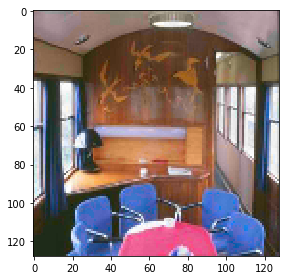

In [12]:
batch = np.load("C:/Users/carlos/Documents/Image_Colorization/Train_Class_batches_batch_1001.npy")
buckets = np.load("pts_in_hull.npy")
image = batch[0]
new_image = np.zeros((image_size, image_size, 3))
new_image[:, :, 0] = image[:, :, 0]
new_image[:, :, 1:] = buckets[image[:, :, 1]]
io.imshow(color.lab2rgb(new_image))
plt.show()

In [4]:
def preprocess_and_return_X_batch(images):
    X = images[:, :, :, 0]
    X = X - 50
    X = X/50
    X = X.reshape(X.shape+(1,))
    return X

In [19]:
rebalance.shape

(313,)

In [25]:
def decode_bucketize_batch(images, rebalance, identity):
    bucketized = np.zeros((images.shape[0], image_size, image_size, 313))
    bucketized = identity[images[... , 1]]
    return bucketized.reshape(images.shape[0], image_size*image_size, 313)

In [ ]:
np.load("F:/Image_Colorization/data/Train_small_batches/batch_1.npy")

In [ ]:
for index, image in enumerate(os.listdir(directory)):
    print(index, image)

In [ ]:
os.listdir("F:/Image_Colorization/data/Validation/")

In [ ]:
encoded = np.load("F:/Image_Colorization/data/Train_small/Train_small_1/Places365_test_00000006.npy")
bucketized = bucketize(encoded, rebalance)
new_image = np.zeros((image_size, image_size, 3))
new_image[:, :, 0] = encoded[:, :, 0]
new_image[:, :, 1:] = buckets[np.argmax(bucketized, axis=2)]
io.imshow(color.lab2rgb(new_image))
plt.show()

In [ ]:
io.imshow(color.lab2rgb(images[2]))
plt.show()

In [ ]:
Y = np.empty((16, 128*128, 313))
buckets = np.load("pts_in_hull.npy")
rebalance = np.load("rebalance.npy")
for index, image in enumerate(images):
    Y[index,] = bucketize_gaussian(image[:, :, 1:], buckets, rebalance)

In [ ]:
def bucketize_gaussian(imageAB, buckets, rebalance):
    #calculate the distances from each pixel to each bucket
    distances = np.zeros((image_size*image_size, buckets.shape[0]))
    distances = cdist(imageAB.reshape(image_size*image_size, 2), buckets)
    #find five shortest ones
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :5]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
    #zero the others
    vertical_indices = np.arange(image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
    #pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    distances = distances * np.expand_dims(rebalance[np.argmax(distances, axis=1)], axis=1)
    return distances

In [ ]:
buckets = np.load("pts_in_hull.npy")
def bucketize_gaussian(image, buckets):
#     get ab channels only
    imagesAB = images[:, :, :, 1:]
#     calculate the distances from each pixel to each bucket
    distances = np.zeros((5*image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(5*image_size*image_size, 2), buckets)
#     find five shortest ones  
    shortest_distances_indices = np.argpartition(distances, 5)
    print(shortest_distances_indices)
    five_shortest_distances_indices = shortest_distances_indices[:, :4]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
#     zero the others
    vertical_indices = np.arange(5*image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
#     pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(5, image_size, image_size, 313)
bucketize_gaussian(images, buckets)

In [ ]:
buckets = np.load("pts_in_hull.npy")
def bucketize_gaussian_tf(inputs):
    batch_size = inputs['batches']
    imagesAB = inputs['images']
    buckets = inputs['buckets']

    #calculate the distances from each pixel to each bucket
    distances = np.zeros((batch_size*image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(batch_size*image_size*image_size, 2), buckets)
    #find five shortest ones
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :5]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
    #zero the others
    vertical_indices = np.arange(batch_size*image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
    #pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(batch_size, image_size, image_size, 313)

inputs_tensor = tf.convert_to_tensor(images[:, :, :, 1:])
buckets_tensor = tf.convert_to_tensor(buckets)
inputs = {'images': inputs_tensor, 'buckets': buckets_tensor, 'batches': 32}
# image = np.zeros((128, 128, 314))
# image[:, :, 0] = images[1, :, :, 0]
image[:, :, 1:] = bucketize_gaussian(images[1, :, :, 1:], buckets, 1)
# np.save("image.npy", image)
imageToRecover = np.load("image.npy")
imageRecover = np.zeros((128, 128, 3))
imageRecover[:, :, 0] = imageToRecover[:, :, 0]
imageRecover[:, :, 1:] = buckets[np.argmax(imageToRecover[:, :, 1:], axis=2)]
io.imshow(color.lab2rgb(imageRecover))
plt.show()

In [ ]:
buckets = np.load("pts_in_hull.npy")
def bucketize_gaussian(imagesAB, buckets, batch_size):
    #calculate the distances from each pixel to each bucket
    distances = np.zeros((batch_size*image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(batch_size*image_size*image_size, 2), buckets)
    #find five shortest ones
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :5]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
    #zero the others
    vertical_indices = np.arange(batch_size*image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
    #pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(batch_size, image_size, image_size, 313)

# image = np.zeros((128, 128, 314))
# image[:, :, 0] = images[1, :, :, 0]
# image[:, :, 1:] = bucketize_gaussian(images[1, :, :, 1:], buckets, 1)
# np.save("image.npy", image)
image_bucketized = bucketize_gaussian(images[1, :, :, 1:], buckets, 1)
# np.save("image.npy", image)
#imageToRecover = np.load("image.npy")
imageRecover = np.zeros((128, 128, 3))
imageRecover[:, :, 0] = images[1, :, :, 0]
imageRecover[:, :, 1:] = buckets[np.argmax(images[1, :, :, 1:], axis=2)]
io.imshow(color.lab2rgb(imageRecover))
plt.show()

In [ ]:
buckets = np.load("pts_in_hull.npy")
def bucketize_gaussian(imagesAB, buckets):
    #calculate the distances from each pixel to each bucket
    distances = np.zeros((image_size*image_size, buckets.shape[0]))
    distances = cdist(imagesAB.reshape(image_size*image_size, 2), buckets)
    #find five shortest ones
    shortest_distances_indices = np.argpartition(distances, 5)
    five_shortest_distances_indices = shortest_distances_indices[:, :5]
    not_five_shortest_distances_indices = np.argpartition(distances, 5)[:, 5:]
    #zero the others
    vertical_indices = np.arange(image_size*image_size)[:, np.newaxis]
    distances[vertical_indices, not_five_shortest_distances_indices] = 0
    #pass gaussian kernel and normalize 5 shortest distances
    weights = np.exp(-distances[vertical_indices, five_shortest_distances_indices]**2/(2*5**2))
    weights_norm = weights/np.sum(weights, axis=1, keepdims=True)
    distances[vertical_indices, five_shortest_distances_indices] = weights_norm
    return distances.reshape(image_size, image_size, 313)

image_bucketized = bucketize_gaussian(images[1, :, :, 1:], buckets)
# np.save("image.npy", image)
#imageToRecover = np.load("image.npy")
imageRecover = np.zeros((128, 128, 3))
imageRecover[:, :, 0] = images[1, :, :, 0]
imageRecover[:, :, 1:] = buckets[np.argmax(image_bucketized, axis=2)]
io.imshow(color.lab2rgb(imageRecover))
plt.show()

In [ ]:
def bucketize(image, rebalance):
    identity = np.identity(313).astype(float)
    bucketized = np.zeros((image_size, image_size, 313))
    bucketized = identity[image[:, :, 1]]
    bucketized = bucketized * np.expand_dims(rebalance[np.argmax(bucketized, axis=2)], axis=2)
    return bucketized

In [ ]:
def bucketize_batch(images, rebalance):
    identity = np.identity(313).astype(float)
    bucketized = np.zeros((images.shape[0], image_size, image_size, 313))
    bucketized = identity[images[... , 1]]
    bucketized = bucketized * np.expand_dims(rebalance[np.argmax(bucketized, axis=3)], axis=3)
    return bucketized

In [ ]:
rebalance = np.load("rebalance.npy")
image1 = np.load("F:/Image_Colorization/data/Train_small/Train_small_1/Places365_test_00000006.npy")
image2 = np.load("F:/Image_Colorization/data/Train_small/Train_small_1/Places365_test_00000007.npy")
images = np.stack((image1, image2))
images = bucketize_batch(images, rebalance)
imagesValues = np.max(images[0], axis=2)

In [ ]:
def closest_buckets(imageAB, buckets):
    #calculate the distances from each pixel to each bucket
    distances = np.zeros((image_size*image_size, 313))
    distances = cdist(imageAB.reshape(image_size*image_size, 2), buckets)
    #find closest one
    shortest_distance_indices = np.argmin(distances, axis=1)
    return shortest_distance_indices.reshape(image_size, image_size)

# cl_bk = closest_buckets(images[8, :, :, 1:], buckets, 1)
# image = np.zeros((128, 128, 314))
# image[:, :, 0] = images[1, :, :, 0]
# image[:, :, 1:] = bucketize_gaussian(images[1, :, :, 1:], buckets, 1)
# np.save("image.npy", image)
# imageToRecover = np.load("image.npy")
# imageRecover = np.zeros((128, 128, 3))
# imageRecover[:, :, 0] = imageToRecover[:, :, 0]
# imageRecover[:, :, 1:] = buckets[np.argmax(imageToRecover[:, :, 1:], axis=2)]
# io.imshow(color.lab2rgb(imageRecover))
# plt.show()

In [ ]:
def encode_buckets_image(image, buckets):
    closest = closest_buckets(image[:, :, 1:], buckets)
    new_image = np.zeros((image_size, image_size, 2), dtype=int)
    new_image[:, :, 0] = image[:, :, 0].astype(int)
    new_image[:, :, 1] = closest
    return new_image.astype(int)

In [ ]:
rebalance = np.load("rebalance.npy")
buckets = np.load("pts_in_hull.npy")
encoded = encode_buckets_image(images[2], buckets)
bucketized = bucketize(encoded, rebalance)
new_image = np.zeros((image_size, image_size, 3))
new_image[:, :, 0] = encoded[:, :, 0]
new_image[:, :, 1:] = buckets[np.argmax(bucketized, axis=2)]
io.imshow(color.lab2rgb(new_image))
plt.show()

In [ ]:
identity = np.identity(3)
b = np.zeros((2, 2, 2), dtype=int)
b[0, 0, 0] = 
identity[b][0, 0, 0]

In [ ]:
bucketized = bucketize_gaussian(images, buckets)
reverted = np.zeros((image_size, image_size, 3))
reverted[:, :, 0] = images[1, :, :, 0]
reverted[:, :, 1:] = buckets[np.argmax(bucketized[1], axis=2)]
io.imshow(color.lab2rgb(reverted))
plt.show()

In [ ]:
# colors = np.arange(-135, 145, 10)
# bins_to_colors = np.arange(-130, 140, 10)
# bins_to_colors[0] = -128
# bins_to_colors[-1] = 127
# print(bins_to_colors)
# bins = np.zeros((5, image_size, image_size))
# binned = np.zeros((5, image_size, image_size, 676))
# # image_colors_positived = images[:, :, :, 1:] + 133
# image_colors_in_bins = np.digitize(images[:, :, :, 1:], colors)
# image_colors_in_bins = image_colors_in_bins - 1
# one_hot = np.eye(676)
# bins = 26*image_colors_in_bins[:, :, :, 0] + image_colors_in_bins[:, :, :, 1]
# binned[:, :, :] = one_hot[bins[:, :, :]]
# print np.argwhere(binned[1]==1)[:, 2].reshape((image_size, image_size))

In [ ]:
# reverted_image = np.zeros((image_size, image_size, 3)).astype(int)
# image_binned = np.argwhere(binned[2, :, :]==1)[:, 2].reshape((image_size, image_size))
# reverted_image[:, :, 0] = images[2, :, :, 0]
# reverted_image[:, :, 2] = np.mod(image_binned ,np.full((image_size, image_size), 26))
# reverted_image[:, :, 1] = (image_binned - reverted_image[:, :, 2]) / 26


# reverted_image[:, :, 1:] = bins_to_colors[reverted_image[:, :, 1:]]
# reverted_image = reverted_image*1.0
# io.imshow(color.lab2rgb(reverted_image))

# plt.show()